# Homework on two-way fixed effects

*29 September, 2021*

The goal of the following homework is to develop our understanding of two-way fixed effect models. 

Related papers:
 - the original paper by [Abowd, Kramarz, and Margolis](https://onlinelibrary.wiley.com/doi/abs/10.1111/1468-0262.00020).
 - [Andrews et al paper](https://www.jstor.org/stable/30135090)
 

## Preparing the environment

In [93]:
using Distributions 
using LinearAlgebra
using StatsBase
using DataFrames 
using Plots
using Chain
using StatsBase
using ShiftedArrays
using DataFramesMeta 

## Constructing Employer-Employee matched data

### Create a mobility matrix

One central piece is to have a network of workers and firms over time. We start by simulating such an object. The rest of the homework will focus on adding wages to this model. As we know from the lectures, a central issue of the network will be the number of movers.

We are going to model the mobility between workers and firms. Given a transition matrix we can solve for a stationary distribution, and then construct our panel from there.

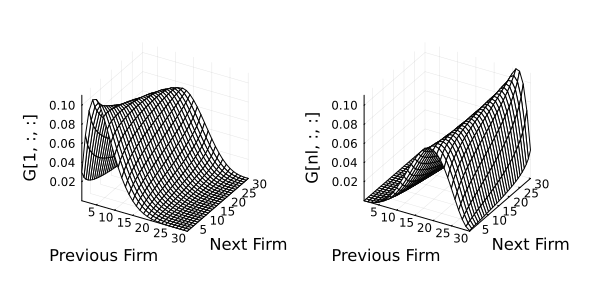

In [3]:
α_sd = 1 
ψ_sd = 1 

# approximate each distribution with some points of support
nk = 30
nl = 10
ψ = quantile.(Normal(), (1:nk) / (nk + 1)) * α_sd
α = quantile.(Normal(), (1:nl) / (nl + 1)) * ψ_sd

# Let's assume moving probability is fixed
λ = 0.1

csort = 0.5 # Sorting effect
cnetw = 0.2 # Network effect
csig  = 0.5 # Cross-sectional standard deviation

# Let's create type-specific transition matrices
# We are going to use joint normals centered on different values
G = zeros(nl, nk, nk)
for l in 1:nl, k in 1:nk
    G[l, k, :] = pdf.( Normal(0, csig), ψ .- cnetw * ψ[k] .- csort * α[l]) 
    G[l, k, :] = G[l, k, :] ./ sum(G[l, k, :])
end

# We then solve for the stationary distribution over psis for each alpha value
# We apply a crude fixed point approach
H = ones(nl, nk) ./ nk
for l in 1:nl
    M = transpose(G[l, :, :])
    for i in 1:100
        H[l, :] = M * H[l, :]
    end
end

p1 = plot(G[1, :, :], xlabel="Previous Firm", ylabel="Next Firm", zlabel="G[1, :, :]", st=:wireframe)
p2 = plot(G[nl, :, :], xlabel="Previous Firm", ylabel="Next Firm", zlabel="G[nl, :, :]", st=:wireframe, right_margin = 10Plots.mm) # right_margin makes sure the figure isn't cut off on the right
plot(p1, p2, layout = (1, 2), size=[600,300])

And we can plot the joint distribution of matches

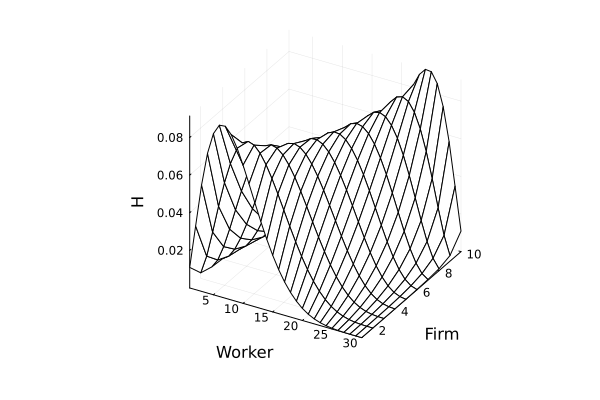

In [4]:
plot(H, xlabel="Worker", ylabel="Firm", zlabel="H", st=:wireframe)

<span style="color:green">Question 1</span>

 - Explain what the parameters `cnetw` and  `csort` do.

 The parameters cnetw and csort embed network effects and sorting effects into the mobility matrix. These alter the transition probabilities for conditional on being at a particular firm type, and being a particular worker type respectively. 


### Simulate a panel

The next step is to simulate our network given our transition rules.

In [5]:
nt = 10
ni = 10000

# We simulate a balanced panel
ll = zeros(Int64, ni, nt) # Worker type
kk = zeros(Int64, ni, nt) # Firm type
spellcount = zeros(Int64, ni, nt) # Employment spell

for i in 1:ni
    
    # We draw the worker type
    l = rand(1:nl)
    ll[i,:] .= l
    
    # At time 1, we draw from H
    kk[i,1] = sample(1:nk, Weights(H[l, :]))
    
    for t in 2:nt
        if rand() < λ
            kk[i,t] = sample(1:nk, Weights(G[l, kk[i,t-1], :]))
            spellcount[i,t] = spellcount[i,t-1] + 1
        else
            kk[i,t] = kk[i,t-1]
            spellcount[i,t] = spellcount[i,t-1]
        end
    end
    
end

### Attach firm ids to types

The final step is to assign identities to the firms. We are going to do this is a relatively simple way, by simply randomly assigning firm ids to spells.

In [34]:
firms_per_type = 15
jj = zeros(Int64, ni, nt) # Firm identifiers

draw_firm_from_type(k) = sample(1:firms_per_type) + (k - 1) * firms_per_type

for i in 1:ni
    
    # extract firm type
    k = kk[i,1]
    
    # We draw the firm (one of firms_per_type in given group)
    jj[i,1] = draw_firm_from_type(k)
    
    for t in 2:nt
        if spellcount[i,t] == spellcount[i,t-1]
            # We keep the firm the same
            jj[i,t] = jj[i,t-1]
        else
            # We draw a new firm
            k = kk[i,t]
            
            new_j = draw_firm_from_type(k)            
            # Make sure the new firm is actually new
            while new_j == jj[i,t-1]
                new_j = draw_firm_from_type(k)
            end
            
            jj[i,t] = new_j
        end
    end
end

# Make sure firm ids are contiguous
contiguous_ids = Dict( unique(jj) .=> 1:length(unique(jj))  )
jj .= getindex.(Ref(contiguous_ids),jj);

444

<span style="color:green">Question 2</span>

 - Explain the last 2 lines, in particular `.=>` and the use of `Ref`. 

'.=>' maps the unique firms generated in jj to keys/ids generated by the line 1:length(unique(jj)). This is then saved as a dictionary. The jj matrix is then updated to reflect these unique firm identifiers, where 'Ref' serves as a reference to the dictionary created in the second-last line. 

In [26]:
ii = repeat(1:ni,1,nt)
tt = repeat((1:nt)',ni,1)
df = DataFrame(i=ii[:], j=jj[:], l=ll[:], k=kk[:], α=α[ll[:]], ψ=ψ[kk[:]], t=tt[:], spell=spellcount[:]);

<span style="color:green">Question 3</span>

Use `Chain.jl` and `DataFramesMeta.jl` to compute:

 - mean firm size, in the crossection, expect something like 15.
 - mean number of movers per firm in total in our panel.


In [48]:
# obtain the firm size in the cross-section (that is, within groups defined by j and t)
mean_size = @chain df begin
    groupby([:j, :t])
    combine(nrow => :size)
    sort(:size, rev=true)
    df_grouped = DataFrame
end

avg_firm_size = mean(df_grouped.size)

# obtain the mean number of movers per firm in total 
mean_movers_vector = zeros(length(unique(df.j))) 

mean_spell = @chain df begin
    groupby([:j, :i])
    combine(:spell => mean)
    sort!([:j, :i, :spell_mean])
    df_grouped_spells_mean = DataFrame
end

df_grouped_spells_mean = df_grouped_spells_mean[df_grouped_spells_mean.spell_mean .< 10, :]

mean_spell = @chain df_grouped_spells_mean begin
    groupby([:j])
    combine(nrow => :movers)
    df_grouped_spells_mean = DataFrame
end

avg_firm_movers = mean(df_grouped_spells_mean.movers)

I find the average size of the firm to be 22 and each firm has about 42 movers on average across the time periods. 

## Simulating AKM wages and create Event Study plot

We start with just AKM wages, which is log additive with some noise.

In [49]:
w_sigma = 0.2
df[!, :lw] = df.α + df.ψ + w_sigma * rand(Normal(), size(df)[1]);

<span style="color:green">Question 4</span>

Before we finish with the simulation code. Use this generated data to create the event study plot from [Card. Heining, and Kline](https://doi.org/10.1093/qje/qjt006):

1. Compute the mean wage within firm
2. Group firms into quartiles
3. Select workers around a move (2 periods pre, 2 periods post)
4. Compute wages before/after the move for each transition (from each quartile to each quartile)
5. Plot the lines associated with each transition

In [101]:
# obtain the mean wage for each firm, across all time periods 
mean_wage = @chain df begin
    groupby([:j])
    combine(:lw => mean)
    sort!([:j, :lw_mean])
    DataFrame
end

# group firms into quartiles based on the mean wage 
quartiles = quantile(mean_wage.lw_mean, [0, 0.25, 0.5, 0.75, 1])
mean_wage.quartile .= 0 
mean_wage[mean_wage.lw_mean .<= quartiles[1], :quartile] .= 1 
mean_wage[(mean_wage.lw_mean .> quartiles[1]) .&& (mean_wage.lw_mean .<= quartiles[2]), :quartile] .= 2 
mean_wage[(mean_wage.lw_mean .> quartiles[2]) .&& (mean_wage.lw_mean .<= quartiles[3]), :quartile] .= 3
mean_wage[(mean_wage.lw_mean .> quartiles[3]), :quartile] .= 4

df_quartiles = innerjoin(df, mean_wage, on=:j)

# identify moves 
df_quartiles.lagged_employer = [missing; df_quartiles.j[1:end-1]] # this creates a variable with the lagged employer but accounts for the first observation. 
# get the quartile of previous employer 
df_quartiles.prev_quartile = [missing; df_quartiles.quartile[1:end-1]] # this creates a variable with the lagged employer but accounts for the first observation. 
# note that the above line does not account for the first time period for each i- need to account for this when we define a mover 
df_quartiles.move .= 0 
df_quartiles[(df_quartiles.t .!= 1) .& (df_quartiles.j .!= df_quartiles.lagged_employer), :move] .= 1

# obtain the leads and lags 
wage_vector = vec(df_quartiles.lw)
wage_vector_lag_1 = ShiftedArrays.lag(wage_vector, 1)
wage_vector_lag_2 = ShiftedArrays.lag(wage_vector, 2)

wage_vector_leads_1= ShiftedArrays.lead(wage_vector, 1)
wage_vector_leads_2 = ShiftedArrays.lead(wage_vector, 2)

df_quartiles.lw_lag_1 = wage_vector_lag_1
df_quartiles.lw_lag_2 = wage_vector_lag_2
df_quartiles.lw_lead_1 = wage_vector_leads_1
df_quartiles.lw_lead_2 = wage_vector_leads_2

# restrict sample to moves 
df_quartiles_moves = df_quartiles[(df_quartiles.move .== 1) .& (df_quartiles.t .> 2) .& (df_quartiles.t .<= 8), :]

# code up moves based on shifts in quartiles 




,i,j,l,k,α,ψ,t,spell,lw,lw_mean
,Int64,Int64,Int64,Int64,Float64,Float64,Int64,Int64,Float64,Float64
1,1,115,10,19,1.33518,0.286894,8,1,1.90075,0.46725
2,2,57,9,24,0.908458,0.752729,7,1,1.29838,1.46868
3,3,312,8,21,0.604585,0.460495,5,1,0.979761,0.951323
4,4,167,5,21,-0.114185,0.460495,3,1,0.38115,0.842767
5,7,219,7,16,0.348756,0.0404405,4,1,0.350828,0.0834423
6,8,230,1,8,-1.33518,-0.649324,7,1,-2.04208,-1.40032
7,11,258,8,16,0.604585,0.0404405,8,1,0.531146,0.0584507
8,13,261,9,11,0.908458,-0.372289,3,1,0.576568,-0.709129
9,14,368,1,9,-1.33518,-0.552443,4,1,-1.73946,-1.13374


## Calibrating the parameters

<span style="color:green">Question 5</span>

 - Pick the parameters `psi_sd`, `alpha_sd`, `csort`, `csig`, and `w_sigma` to roughly match the decomposition in the Card-Heining-Kline paper (note that they often report numbers in standard deviations, not in variances).

## Estimating two-way fixed effects

This requires first extracting the large set of firms connected by movers, and then estimating the linear problem with many dummies.

### Extracting the connected set

Because we are not going to deal with extremely large data-sets, we can use off-the-shelf algorithms to extract the connected set. Use the function `connected_components` from the package `LightGraphs` to extract the connected set from our data. To do so you will need to first construct an adjacency matrix between the firms. 

<span style="color:green">Question 6</span>

 - Extract the connected set and drop firms not in the set (I expect that all firms will be in the set).

### Estimating worker and firm FEs

This part of the problem set is for you to implement the AKM estimator. As discussed in class, this can be done simply by updating, in turn, the worker FE and the firm FE.

Start by appending 2 new columns `alpha_hat` and `psi_hat` to your data. Then loop over the following:

1. Update `alpha_hat` by taking the mean within `i` net of firm FE
2. Update `psi_hat` by taking the mean within `fid` net of worker FE

<span style="color:green">Question 7</span>

 - Run the previous steps in a loop, and at each step evaluate how much the total mean square error has changed. Check that is goes down with every step. Stop when the MSE decreases by less than 1e-9.


Note that you can increase speed by focusing on movers only first.



## Limited mobility bias 

We now have everything we need to look at the impact of limited mobility bias. Compute the following:

1. Compute the estimated variance of firm FE
2. Do it for varying levels of mobility λ. For each the number of movers, collect the actual variance and the estimated variance. Run it for different panel lengths: 5, 6, 8, 10, 15.

<span style="color:green">Question 8</span>

 - Report this in a plot. This should look like the [Andrews et al.](https://www.sciencedirect.com/science/article/pii/S0165176512004272) plot.
 - Redo the exercise for the covariance between co-workers fixed effect as discussed in class.

## Correcting the bias (Start of homework 2)

<span style="color:green">Question 9</span>

 - Implement both the exact as well as the approximated (Hutchkinson trace approximation) Andrews et al. type fixed-effect bias correction based on homoskedacity. Redo the plot from Question 6 so that it includes these 2 estimates.

## Evidence of learning

<span style="color:green">Question 10</span>

 - Regress the wage of a worker at time $t$ on his wage at time $t-l$ and the average wage of his co-workers at time $t-l$ for some lags $l$ focusing on workers that did change firms between $t-l$ and $t$. 
 - Comment on the result.
